## Deconvoluting spatialATAC data with Cell2Location

In this tutorial, we go over how to run Cell2Location with deconvATAC.

### Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
from deconvatac.tl import cell2location
from deconvatac.pp import highly_variable_peaks
import scanpy as sc
import pandas as pd
import numpy as np

### Read in the data

We will use the human melanoma dataset by [Russell et al.](https://doi.org/10.1038/s41586-023-06837-4). The data is available for download on [Zenodo](https://zenodo.org/records/15089738). 

In [ ]:
russell_st = sc.read_h5ad("./example_notebooks/cell2location/russell_250_atac.h5ad")
russell_st

AnnData object with n_obs × n_vars = 360 × 53451
    obs: 'cell_count'
    var: 'features'
    uns: 'log1p', 'proportion_names'
    obsm: 'proportions', 'spatial'
    layers: 'log_norm', 'tfidf_normalized'

In [ ]:
russell_sc = sc.read_h5ad("./example_notebooks/cell2location/russel_ref_atac.h5ad")
russell_sc

AnnData object with n_obs × n_vars = 2535 × 53451
    obs: 'barcodes', 'NAME_x', 'X', 'Y', 'cell_type', 'NAME_y', 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'cluster'
    var: 'features'
    uns: 'cell_type_colors', 'log1p'
    obsm: 'X_umap', 'spatial'
    layers: 'log_norm', 'tfidf_normalized'

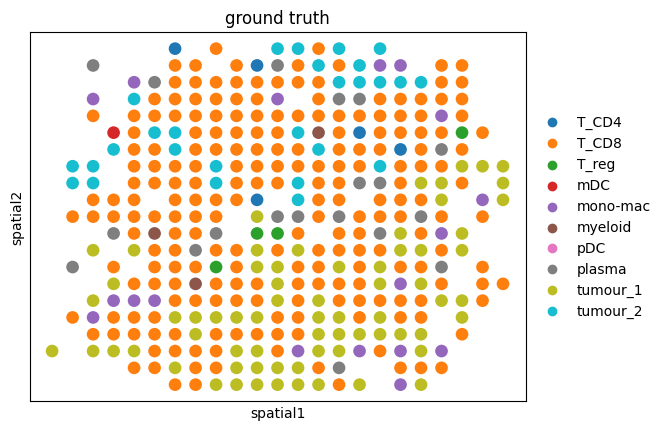

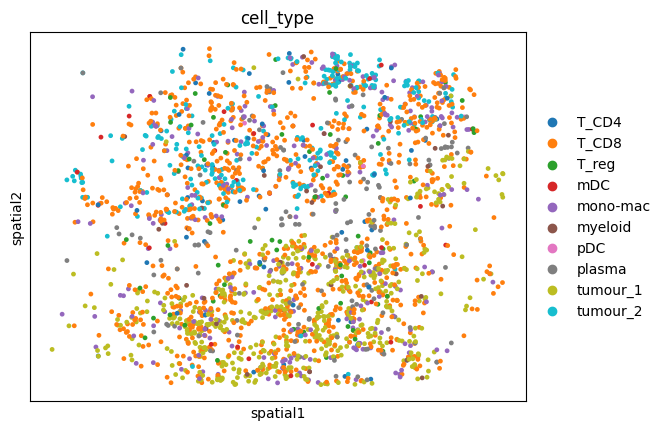

In [4]:
# Calculate the most probable cluster assignment
max_prob_cluster = np.argmax(russell_st.obsm["proportions"], axis=1)
# Get the column names
cluster_id = russell_st.uns["proportion_names"]
russell_st.obs["ground truth"] = cluster_id[max_prob_cluster]
russell_st.obs['ground truth'] = pd.Categorical(russell_st.obs['ground truth'], categories=russell_sc.obs.cell_type.cat.categories)
russell_st.uns["ground truth_colors"] = russell_sc.uns["cell_type_colors"].copy()
sc.pl.embedding(russell_st, basis = "spatial", color = "ground truth")
sc.pl.embedding(russell_sc, basis = "spatial", color = "cell_type")

### Select HVFs with deconvATAC

Before running deconvolution, the feature space should be subsetted onto a smaller space. Since the method of highly variable feature selection shows greater performance than the highly accessible feature approach, we will select features using the [deconvatac.pp.highly_variable_peaks](https://deconvatac.readthedocs.io/en/latest/autoapi/deconvatac/pp/feature_selection/index.html#deconvatac.pp.feature_selection.highly_variable_peaks) function. 

The [deconvatac.pp.highly_variable_peaks](https://deconvatac.readthedocs.io/en/latest/autoapi/deconvatac/pp/feature_selection/index.html#deconvatac.pp.feature_selection.highly_variable_peaks) function selects the highly variable features in place and saves the result to `.var["highly_variable"]`. It takes as input the key in `.obs` of the clusters by which the method identifies highly
variable peaks across. In our case, the `cluster_key` is the cell type.

In [26]:
highly_variable_peaks(adata=russell_sc, cluster_key="cell_type")

In [27]:
russell_st = russell_st[:, russell_sc.var["highly_variable"]]
russell_sc = russell_sc[:, russell_sc.var["highly_variable"]]

### Run Cell2Location

Anndata setup with scvi-tools version 1.0.3.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': 'cell_type',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 2535  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  10   │
│          n_vars          │ 20000 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                    labels State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │   T_CD4    │          0          │
│                        │   T_CD8    │          1          │
│                        │   T_reg    │          2          │
│                        │    mDC     │          3          │
│                        │  mono-mac  │          4          │
│                        │  myeloid   │          5          │
│                        │    pDC     │          6          │
│                        │   plasma   │          7          │
│                        │  tumour_1  │          8          │
│                        │  tumour_2  │          9          │
└────────────────────────┴────────────┴─────────────────────┘

/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /vol/storage/miniconda3/envs/cell2loc_env/lib/python ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is availa

Epoch 400/400: 100%|██████████| 400/400 [16:34<00:00,  2.57s/it, v_num=1, elbo_train=8.85e+6]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [16:34<00:00,  2.49s/it, v_num=1, elbo_train=8.85e+6]


/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /vol/storage/miniconda3/envs/cell2loc_env/lib/python ...
  rank_zero_warn(


Sampling global variables, sample: 100%|██████████| 999/999 [00:18<00:00, 55.49it/s]


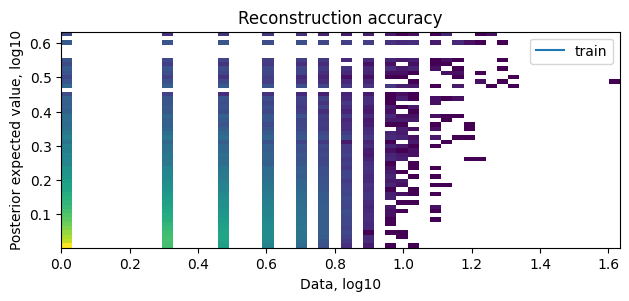

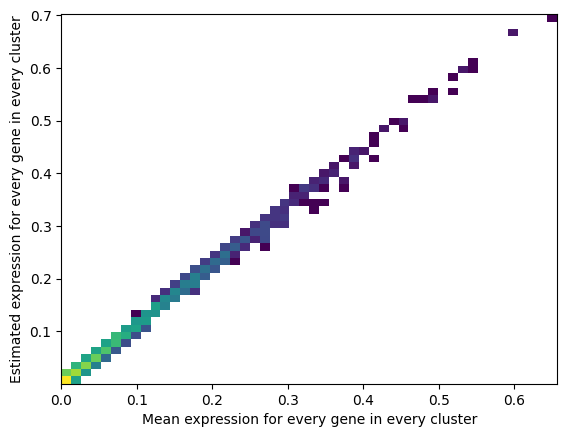

Anndata setup with scvi-tools version 1.0.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │  360  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 20000 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /vol/storage/miniconda3/envs/cell2loc_env/lib/python ...
  rank_zero_warn(
/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is availa

Epoch 400/400: 100%|██████████| 400/400 [01:12<00:00,  6.39it/s, v_num=1, elbo_train=4.14e+6]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:12<00:00,  5.50it/s, v_num=1, elbo_train=4.14e+6]


/vol/storage/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /vol/storage/miniconda3/envs/cell2loc_env/lib/python ...
  rank_zero_warn(


Sampling global variables, sample: 100%|██████████| 999/999 [00:20<00:00, 48.87it/s]


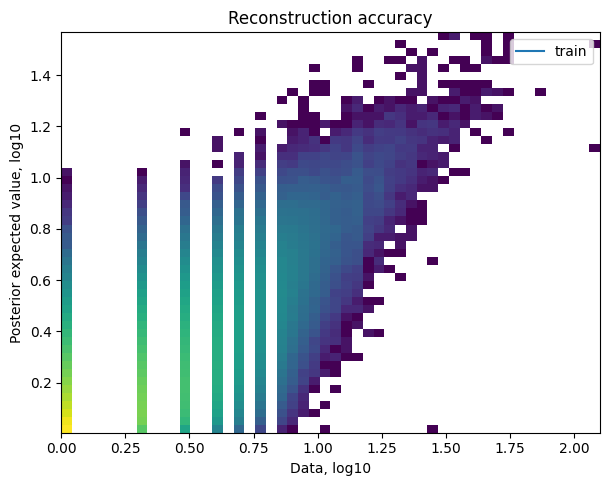

In [16]:
russell_st, russell_sc = cell2location(adata_spatial=russell_st, adata_ref=russell_sc, N_cells_per_location=8, detection_alpha=20
              , labels_key="cell_type", use_gpu=False, max_epochs_spatial=400, max_epochs_ref=400, return_adatas=True)

In the returned `AnnDatas`, we can find the posteriors of the spatial mapping and reference model: 

In [19]:
russell_st, russell_sc

(AnnData object with n_obs × n_vars = 360 × 20000
     obs: 'cell_count', 'leiden_pca', 'leiden_lsi', '_indices', '_scvi_batch', '_scvi_labels'
     var: 'features', 'highly_variable', 'highly_accessible'
     uns: 'leiden', 'log1p', 'lsi', 'neighbors', 'pca', 'proportion_names', '_scvi_uuid', '_scvi_manager_uuid', 'mod'
     obsm: 'X_lsi', 'X_pca', 'proportions', 'spatial', 'means_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf'
     varm: 'LSI', 'PCs'
     layers: 'log_norm', 'tfidf_normalized'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 2535 × 20000
     obs: 'barcodes', 'NAME_x', 'X', 'Y', 'cell_type', 'NAME_y', 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'cluster', '_indices', '_scvi_batch', '_scvi_labels'
     var

The resulting `means_cell_abundance_w_sf` and `q05_cell_abundance_w_sf` cell type abundances are also saved to directory `./cell2location_results`

#### Visualize results

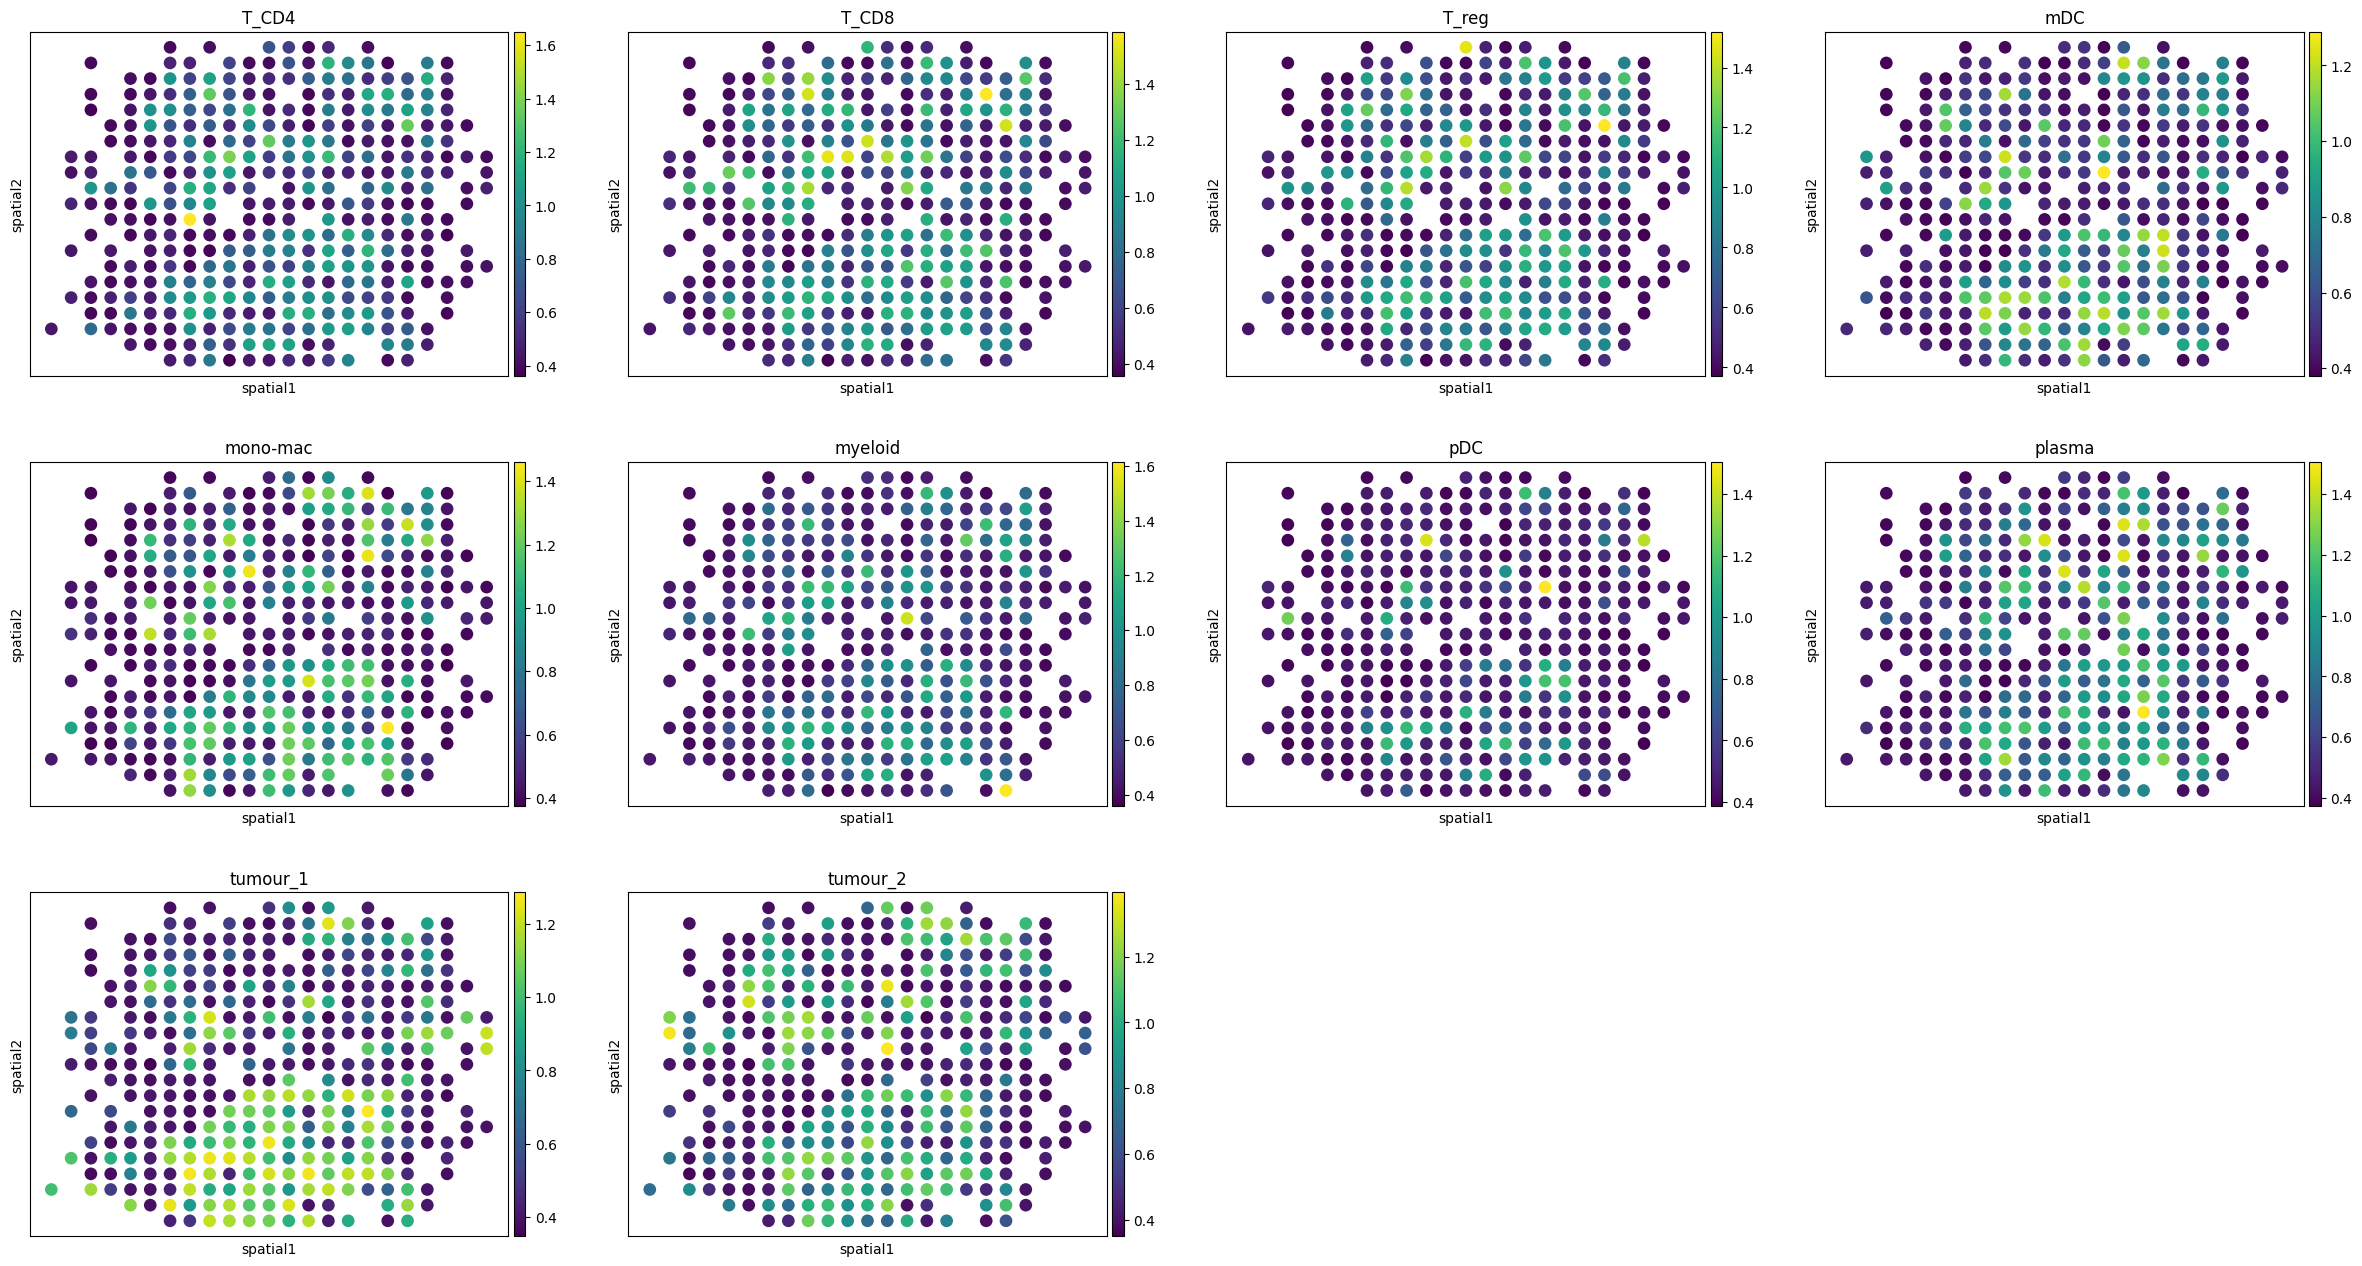

In [6]:
russell_st.obs[russell_st.uns["mod"]["factor_names"]] = russell_st.obsm["q05_cell_abundance_w_sf"]
sc.pl.embedding(russell_st,basis="spatial",color=russell_st.uns["mod"]["factor_names"]) 
